In [ ]:
# Adapted from https://keras.io/examples/vision/mnist_convnet/

In [6]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Create DataFrame for Benford's Law Distribution & define helper functions

In [96]:
# create dataframe with benford's law distribution
benford = pd.DataFrame.from_dict({
    '1': 30.1,
    '2': 17.6,
    '3': 12.5,
    '4': 9.7,
    '5': 7.9,
    '6': 6.7,
    '7': 5.8,
    '8': 5.1,
    '9': 4.6
}, orient= 'index')
benford.columns = ['benford']

In [ ]:
def get_leading_digit(x):
    '''
    Remove negative sign and get first non-zero digit (ignoring decimal) - used with dataframe of weight values to get their leading digit
    '''
    x = str(abs(x))
    if x[0] == '0':
        return str(int(x.split(".")[1]))[0]
    else:
        return x.split(".")[0]

In [ ]:
def plot_benford_for_first_layer(title):
    leading_digits = pd.DataFrame(model.layers[0].get_weights()[0].flatten())
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']

    df[['leading_digit','benford']].plot(kind='bar', title=title, figsize = (20,10))

# Define Keras Model

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________

In [137]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 25s 454us/sample - loss: 0.1087 - acc: 0.9669 - val_loss: 0.0528 - val_acc: 0.9858
Epoch 2/15
54000/54000 [==============================] - 19s 356us/sample - loss: 0.0808 - acc: 0.9750 - val_loss: 0.0429 - val_acc: 0.9887
Epoch 3/15
54000/54000 [==============================] - 23s 418us/sample - loss: 0.0679 - acc: 0.9788 - val_loss: 0.0399 - val_acc: 0.9887
Epoch 4/15
54000/54000 [==============================] - 23s 432us/sample - loss: 0.0599 - acc: 0.9817 - val_loss: 0.0420 - val_acc: 0.9862
Epoch 5/15
54000/54000 [==============================] - 24s 444us/sample - loss: 0.0531 - acc: 0.9834 - val_loss: 0.0377 - val_acc: 0.9888
Epoch 6/15
54000/54000 [==============================] - 33s 615us/sample - loss: 0.0494 - acc: 0.9843 - val_loss: 0.0355 - val_acc: 0.9913
Epoch 7/15
54000/54000 [==============================] - 21s 396us/sample - loss: 0.0453 - acc: 0.9853 -

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Plot weight leading digit distribution vs. Benford's Law

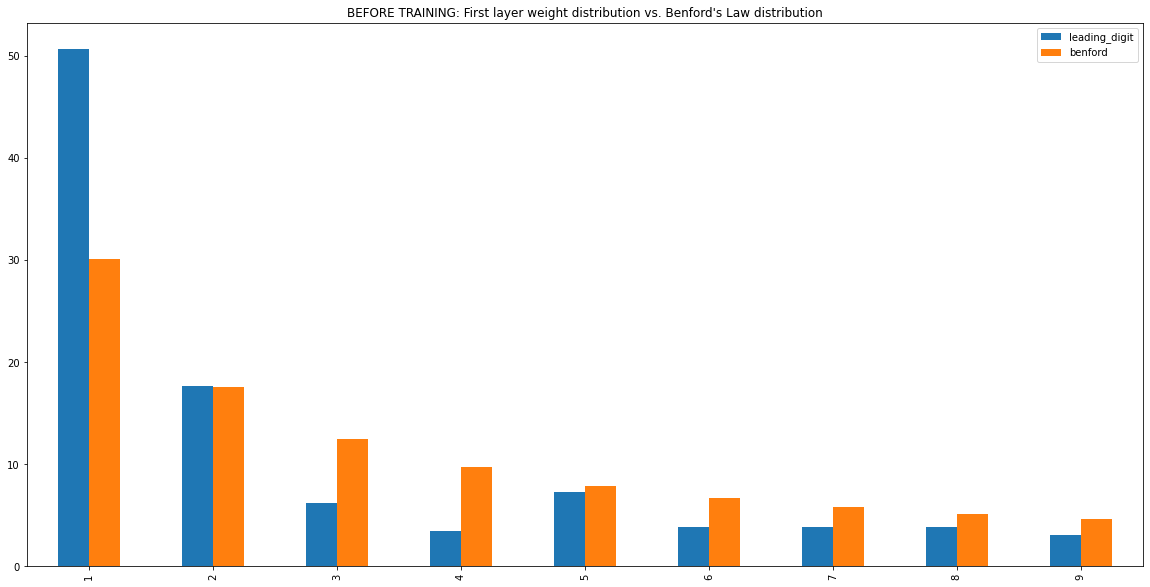

In [136]:
plot_benford_for_first_layer("BEFORE TRAINING: First layer weight distribution vs. Benford's Law distribution")

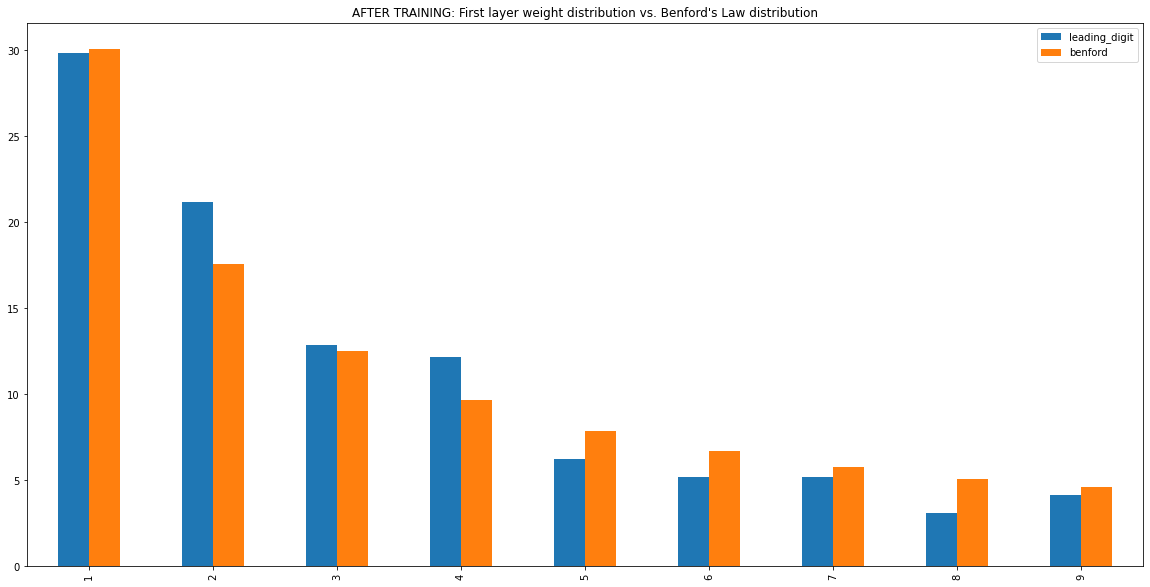

In [138]:
plot_benford_for_first_layer("AFTER TRAINING: First layer weight distribution vs. Benford's Law distribution")